# Model Evaluation

This notebook is for running and documenting experiments

## latentFairClassifier Evaluation

A classifier based on the model described in the paper 
*Group Fairness by Probabilistic Modeling with Latent Fair Decisions* has been 
successfully implemented and trained on the adult dataset. It is time to 
evaluate the model in terms of fairness as well as traditional metrics.

### Import

In [7]:
import pandas as pd
import sys
import os
from sklearn.metrics import roc_curve
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from forseti.datproc import translate_categorical, extract_sensitive
from forseti.fairness import parity_score, fairness_report

### Load Dataset and Predictions 

In [8]:
tmp = pd.read_csv('data/adult.csv')
data, codes = translate_categorical(tmp.copy(deep=True))
sensitive_attributes = ['race', 'gender']

test = data[30000:]

sensitive, features = extract_sensitive(test, sensitive_attributes) 
y = features['income']
X = features.drop('income', axis=1)

y_pred_fair = pd.read_csv('results/y_pred_label_fair.csv', index_col=0)
y_pred_income = pd.read_csv('results/y_pred_label_income.csv', index_col=0)
y_pred_probability = pd.read_csv('results/y_pred.csv', index_col=0)
y_pred_label_NB_sens = pd.read_csv('results/y_pred_label_naive_bayes_sensitive.csv', index_col=0)
y_pred_label_NB_sens.index = y.index
y_pred_label_NB = pd.read_csv('results/y_pred_label_naive_bayes.csv', index_col=0)
y_pred_label_NB.index = y.index
y_pred_prob_NB_sens = pd.read_csv('results/y_pred_probability_naive_bayes_sensitive.csv', index_col=0)
y_pred_prob_NB_sens.index = y.index
y_pred_prob_NB = pd.read_csv('results/y_pred_probability_naive_bayes.csv', index_col=0)
y_pred_prob_NB.index = y.index

### Score metric for demographic parity

Demographic parity is defined as

$$
P(\hat{Y} | S = 0) = P(\hat{Y} | S = 1)
$$

Where $\hat{Y}$ is the predictor and $S$ is the sensitive attribute.

This can be generalised to a multiclass case with $K$ classes.

$$
P(\hat{Y} | S_i) = P(\hat{Y} | S_j) \qquad i, j \in \{0, \dots, K-1\}
$$

We want to condense this to a single metric between $0$ and $1$. I.e, when we 
have likelihood for the different classes of a sensitive attribute in a list of 
probabilities $L$ like so

$$
L =\{ P(\hat{Y} | S=0), \dots, P(\hat{Y} | S=K-1) \}
$$

We would want a score of 1 if that list has probabilities like

$$
L_0 = \{ 0.333, 0.333, 0.333\}
$$

and a score of 0 for

$$
L_1 = \{ 1, 0\}
$$

and for that, we have worked out the following function $f$

$$
    f = 1 - 2\sigma(L)
$$

where $\sigma$ is for standard deviation. The example of which is shown below.

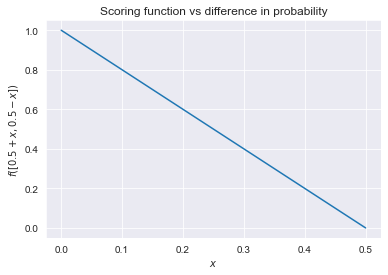

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 0.5, 100)
scores = []

for prob in x:
    scorelist = [0.5 + prob, 0.5 - prob]
    scores.append(parity_score(scorelist))

plt.plot(x, scores);
plt.title('Scoring function vs difference in probability');
plt.xlabel('$x$');
plt.ylabel('$f([0.5+x, 0.5-x])$');
plt.savefig('figures/Parity_metric.png', dpi=200)
plt.show()

In [10]:
fairnessDF = pd.DataFrame()

fairnessDF = fairnessDF.append(fairness_report(y, y_pred_fair, sensitive, 'FairBN'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_income, sensitive, 'IncomeBN'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_label_NB_sens, sensitive, 'NBSens'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_label_NB, sensitive, 'NB'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y, sensitive, 'Dataset'), ignore_index=True);
fairnessDF

C:\Users\bcwei\AppData\Local\Temp/ipykernel_2120/252768235.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fairnessDF = fairnessDF.append(fairness_report(y, y_pred_fair, sensitive, 'FairBN'), ignore_index=True);
C:\Users\bcwei\AppData\Local\Temp/ipykernel_2120/252768235.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fairnessDF = fairnessDF.append(fairness_report(y, y_pred_income, sensitive, 'IncomeBN'), ignore_index=True);
C:\Users\bcwei\AppData\Local\Temp/ipykernel_2120/252768235.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fairnessDF = fairnessDF.append(fairness_report(y, y_pred_label_NB_sens, sensitive, 'NBSens'), ignore_index=True);
C:\Users\bcwei\AppData\Local\Temp/ipykernel_2120/252768235.py:6: FutureW

,Accuracy,Balanced Accuracy,F1 Score,Specificity,Parity Score race,Parity Score gender,Intersectional Parity Score,Model
0,0.82443,0.75570,0.63171,0.88883,0.88455,0.94341,0.86846,FairBN
1,0.83447,0.72144,0.59488,0.94036,0.85123,0.75052,NaN,IncomeBN
2,0.80655,0.79307,0.65726,0.81918,0.77449,0.60527,0.67633,NBSens
3,0.81499,0.79930,0.66781,0.82968,0.81574,0.66148,0.71069,NB
4,1.00000,1.00000,1.00000,1.00000,0.84795,0.80171,0.80854,Dataset


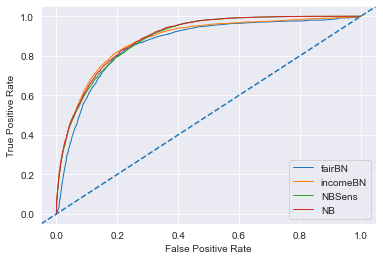

In [6]:
fpr_fair, tpr_fair, threshold = roc_curve(y,  y_pred_probability['fair_0'])
fpr_income, tpr_income, _ = roc_curve(y,  y_pred_probability['income_1'])
fpr_NBsens, tpr_NBsens, _ = roc_curve(y,  y_pred_prob_NB_sens['income_1'])
fpr_NB, tpr_NB, _ = roc_curve(y,  y_pred_prob_NB['income_1'])

#create ROC curve
plt.plot(fpr_fair, tpr_fair, label='fairBN', linewidth=1)
plt.plot(fpr_income, tpr_income, label='incomeBN', linewidth=1)
plt.plot(fpr_NBsens, tpr_NBsens, label='NBSens', linewidth=1)
plt.plot(fpr_NB, tpr_NB, label='NB', linewidth=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axline((1, 1), slope=1, ls="--")
plt.legend()
plt.savefig('figures/baseline_roc.png', dpi=200)
plt.show()